# Calibrated words self-report analysis
Rubia Guerra

Last updated: Apr 12th 2022

### Module definitions

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import glob
import re
import pandas as pd
import scipy.io as sio
import seaborn as sns

plt.style.use("seaborn")

%matplotlib inline

### Import data

In [2]:
def load_dataset(data_dir = '../EEG/data/p*'):
    subject_data_files = glob.glob(os.path.join(data_dir, 'calibrated_words_calibrated_values.mat'))
    subject_data_files.sort()

    timestamps_data_files = glob.glob(os.path.join(data_dir, 'calibrated_words_time*.mat'))
    timestamps_data_files.sort()
    
    subjects_data = []
    for subject_filename, timestamp_filename in zip(subject_data_files, timestamps_data_files):
        subject_data = (sio.loadmat(subject_filename)['var'].ravel() + 10)*10
        timestamp_data = sio.loadmat(timestamp_filename)['var'].ravel()

        df_data = list(zip(timestamp_data, subject_data))        
        df = pd.DataFrame(df_data, columns=['Timestamp', 'Values'])

        p_number = re.findall('p\d+', subject_filename) * df.shape[0]
        df['p_number'] = p_number
        subjects_data.append(df)
    
    return subjects_data

In [3]:
X_list = load_dataset()

In [4]:
X_list[0].head()

,Timestamp,Values,p_number
0,41100,100.0,p10
1,66900,110.0,p10
2,86833,185.0,p10
3,109466,185.0,p10
4,152233,115.0,p10


In [5]:
X = pd.concat(X_list)
X.head()

,Timestamp,Values,p_number
0,41100,100.0,p10
1,66900,110.0,p10
2,86833,185.0,p10
3,109466,185.0,p10
4,152233,115.0,p10


## Calibrated words analyses

### Boxplot

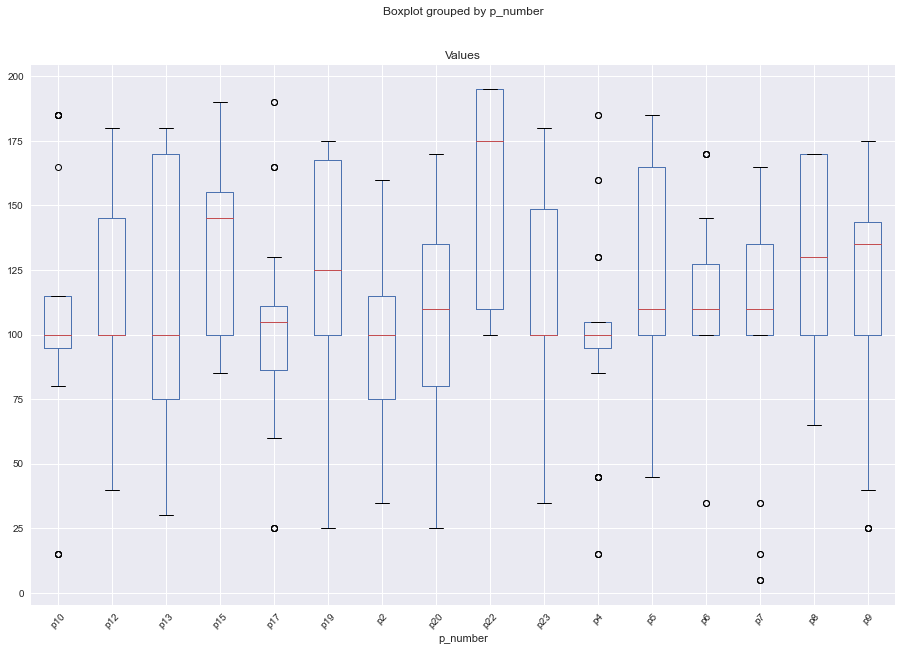

In [6]:
ax = X.boxplot(column='Values', by='p_number', rot=45, figsize=(15,10));

In [7]:
def plot_all_word_values(X, num_columns, figsize_per_row=None):
    X_by_participant = iter(X.groupby('p_number'))
    if figsize_per_row is None:
        figsize_per_row = (25, 15/num_columns)
    try:
        while True:
            # call plt.figure once per row
            fig = plt.figure(figsize=figsize_per_row)
            fig.subplots_adjust(hspace=0.4, wspace=0.4)
            for col in range(num_columns):
                pnum = next(X_by_participant)
                series  = pnum[1].Values
                ax = fig.add_subplot(1, num_columns, col+1)
                ax.plot(series, '-o')
                plt.title(pnum[0])
                plt.ylim([-10, 250])
    except StopIteration:
        pass

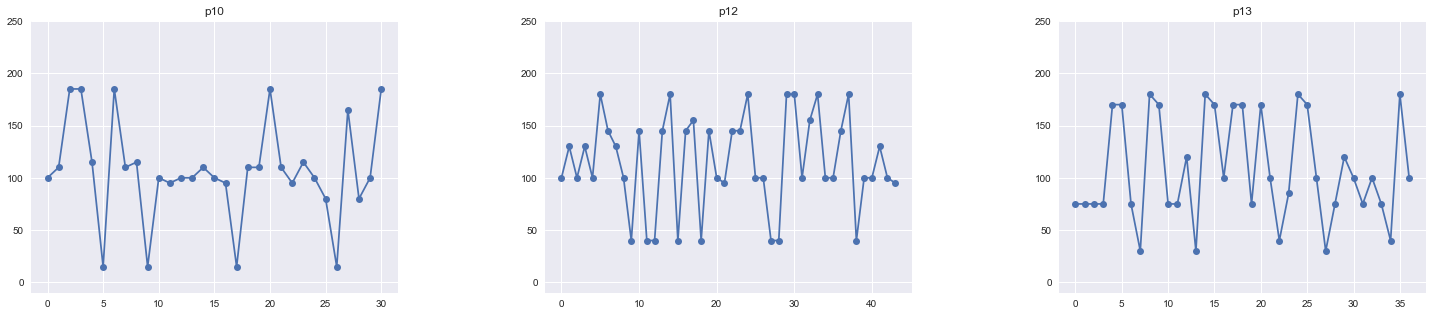

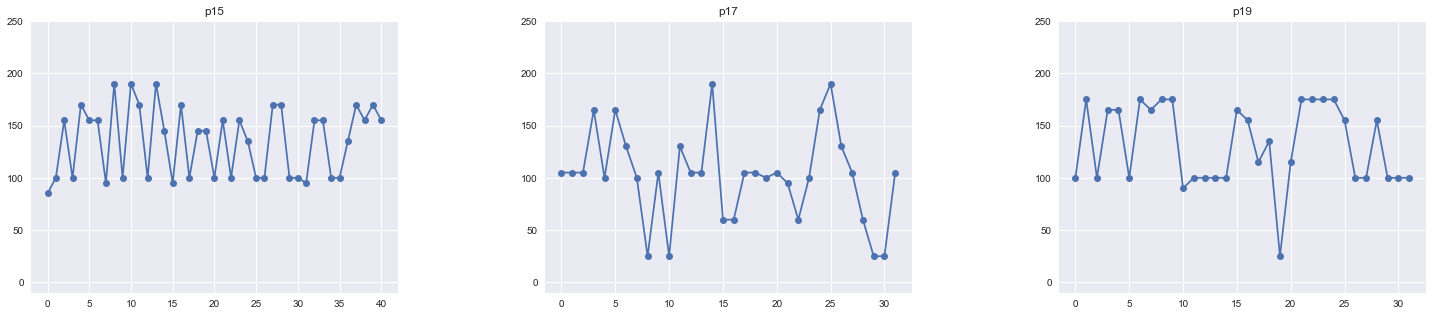

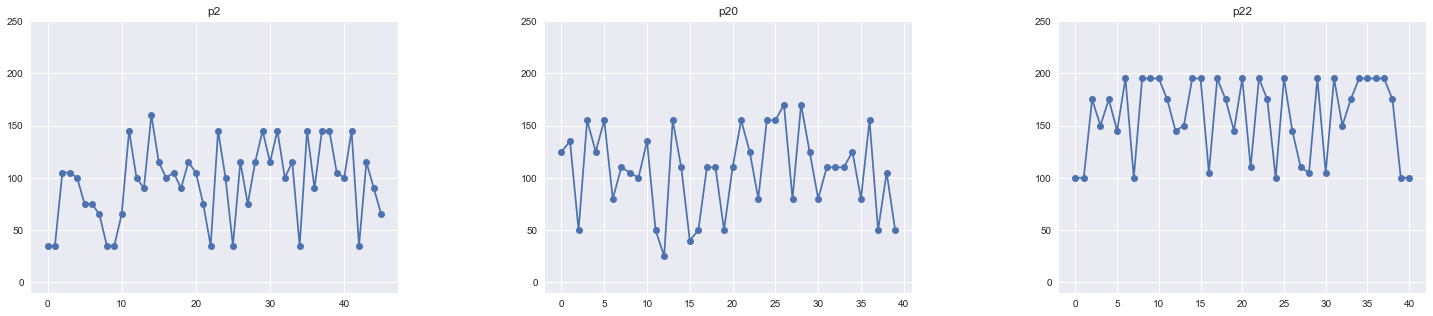

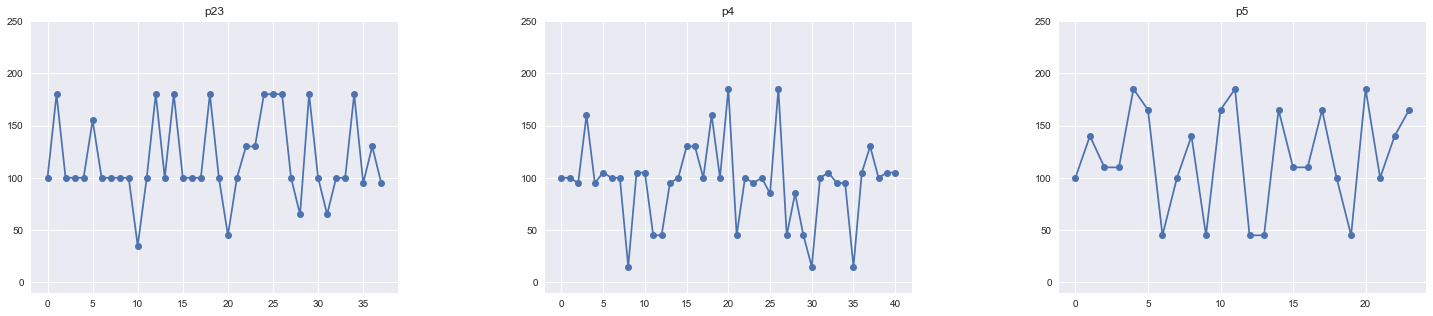

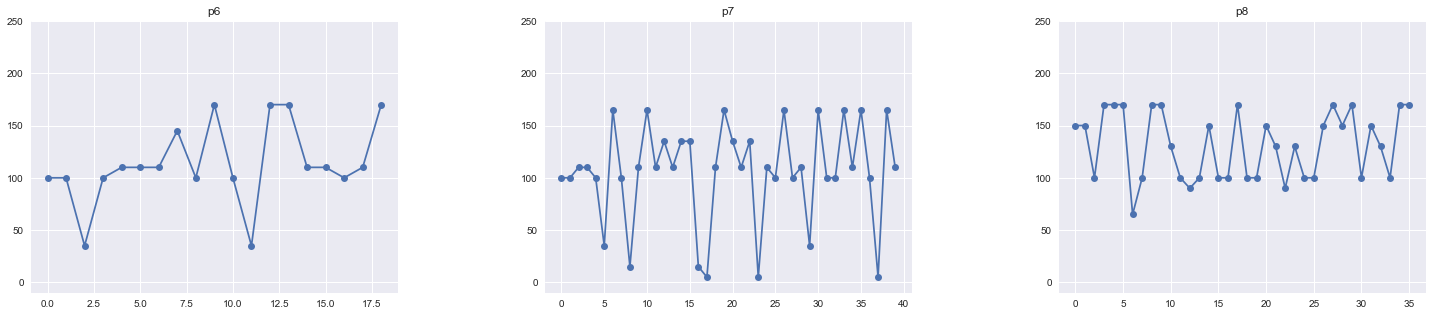

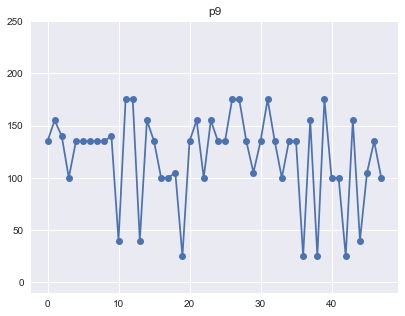

In [8]:
plot_all_word_values(X, 3)

### Autocorrelation analysis

Takeaways:
- Based on the plots below, there seems to be no strong effects of autocorrelation.
- Idea: we could use the last significant lag (e.g. the last lag above 0.2, but have to define this threshold) as a measure for "reaction time" in the continuous annotation pass. In other words, the strong autocorrelation for small lags suggest that the participant takes some time processing their emotions and generating an annotation.

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_autocorr(X, num_columns, lags=None, figsize_per_row=None):
    X_by_participant = iter(X.groupby('p_number'))
    if figsize_per_row is None:
        figsize_per_row = (25, 15/num_columns)
    try:
        while True:
            fig = plt.figure(figsize=figsize_per_row)
            fig.subplots_adjust(hspace=0.4, wspace=0.4)
            for col in range(num_columns):
                pnum = next(X_by_participant)
                series  = pnum[1].Values
                series = series.diff() # detrend
                series[0] = 0
                ax = fig.add_subplot(1, num_columns, col+1)
                plot_acf(series, ax=ax, lags=lags, title=pnum[0], zero=False) # autocorr for all lags < 1 min
                plt.ylim([-1.15,1.15])
    except StopIteration:
        pass

#### Lags up to 1 min

Y-axis: Correlation coefficient (-1 to 1)
X-axis: lag index (0 to 1 min, Fs = 30Hz)

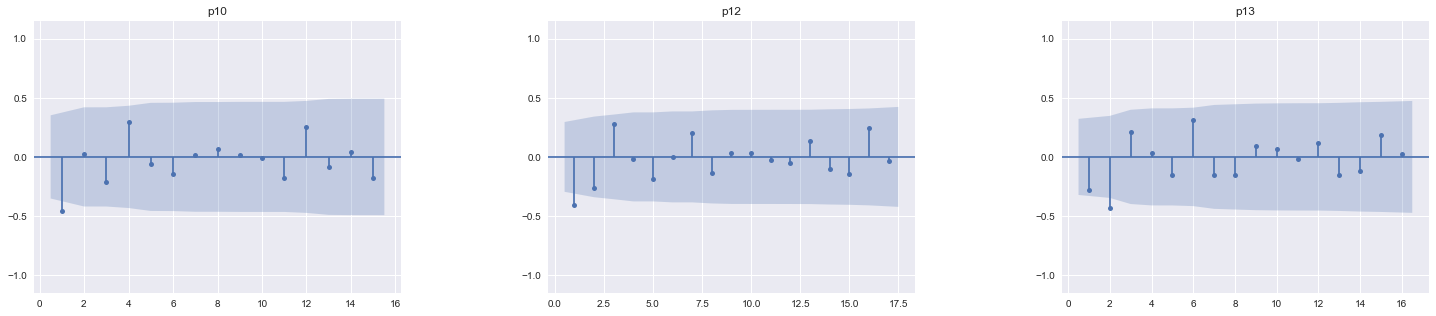

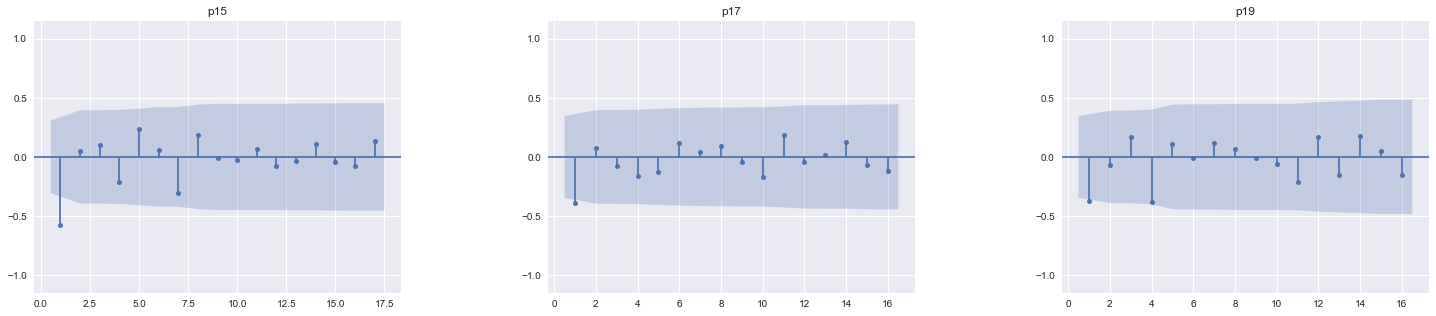

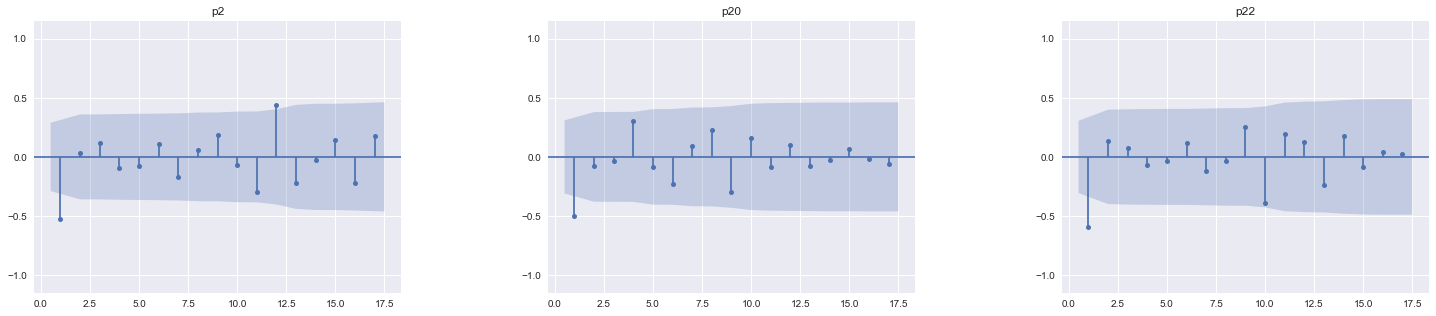

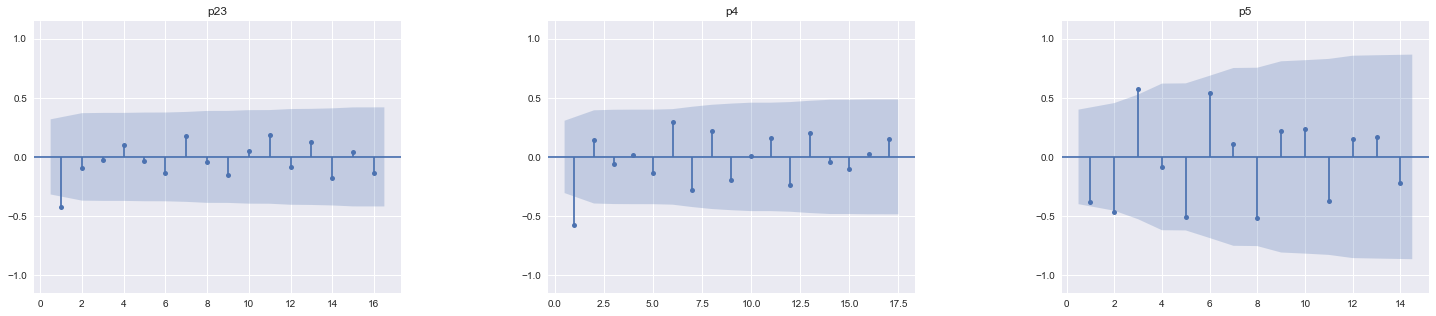

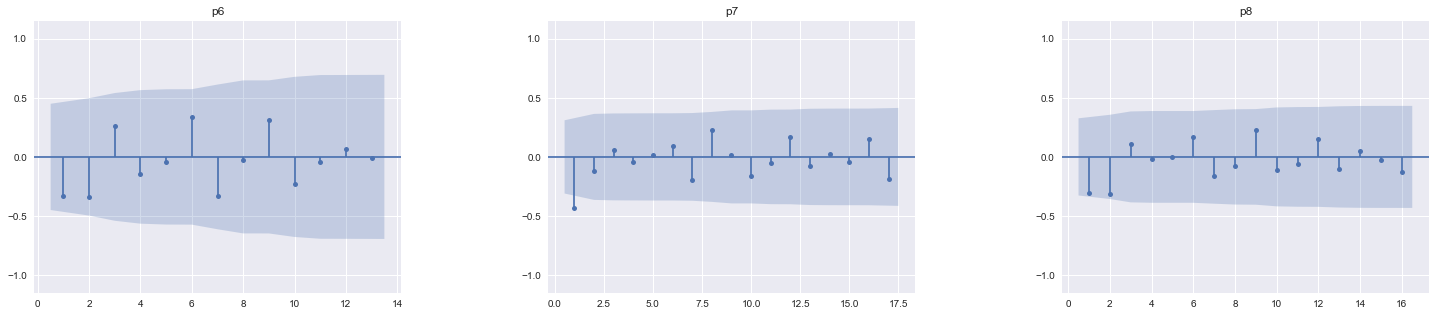

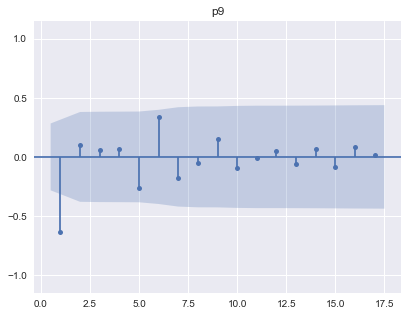

In [10]:
plot_autocorr(X, 3)

#### Note on ACF confidence intervals

From [`statsmodels`](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) documentation:
    
    Confidence intervals for ACF values are generally placed at 2 standard errors around r_k. The formula used for standard error depends upon the situation. If the autocorrelations are being used to test for randomness of residuals as part of the ARIMA routine, the standard errors are determined assuming the residuals are white noise. The approximate formula for any lag is that standard error of each r_k = 1/sqrt(N). See section 9.4 of [1] for more details on the 1/sqrt(N) result. For more elementary discussion, see section 5.3.2 in [2]. For the ACF of raw data, the standard error at a lag k is found as if the right model was an MA(k-1). This allows the possible interpretation that if all autocorrelations past a certain lag are within the limits, the model might be an MA of order defined by the last significant autocorrelation. In this case, a moving average model is assumed for the data and the standard errors for the confidence intervals should be generated using Bartlett’s formula. For more details on Bartlett formula result, see section 7.2 in [1].


### VAR Model

Refer to _Ernst AF, Timmerman ME, Jeronimus BF, Albers CJ. Insight into individual differences in emotion dynamics with clustering. Assessment. 2021 Jun;28(4):1186-206._

*Adapted from [BioSciEconomist/ex VAR.py](https://gist.github.com/BioSciEconomist/197bd86ea61e0b4a49707af74a0b9f9c).

### Emotion dynamics

#### Defining emotion dynamics features
Refer to _Houben M, Van Den Noortgate W, Kuppens P. The relation between short-term emotion dynamics and psychological well-being: A meta-analysis. Psychological bulletin. 2015 Jul;141(4):901._

- **Emotional inertia:** refers to how well the intensity of an emotional state can be predicted from the emotional state at a previous moment.
- **Emotional instability:** refers to the magnitude of emotional changes from one moment to the next. An individual characterized by high levels of instability experiences larger emotional shifts from one moment to the next, resulting in a more unstable emotional life.
- **Emotional variability:** refers to the range or amplitude of someone’s emotional states across time. An individual characterized by higher levels of emotional variability experiences emotions that reach more extreme levels and shows larger emotional deviations from his or her average emotional level

In [12]:
from statsmodels.tsa import stattools

class EmotionDynamics:
    def __init__(self, Fs=30, interval=300):
        self.lag = int(Fs*interval*1e-1) # feeltrace sampling rate x 300 ms

    def emotional_variability(self, X):
        return np.std(X)

    def emotional_instability(self, X):
        return np.sum((X[1:] - X[:-1])**2)/(len(X)-1) # MSSD

    def emotional_inertia(self, X, lag=None):
        if lag is None:
            lag = self.lag
        try:
            return stattools.acf(X, nlags=lag)[lag] # Autocorrelation
        except IndexError:
            return stattools.acf(X, nlags=700)[700] # Autocorrelation

    
    def get_parameters(self, X):
        X = np.array(X)
        parameters = {'Inertia':'', 'Instability':'', 'Variability':''}
        parameters['Inertia'] = self.emotional_inertia(X)
        parameters['Instability'] = self.emotional_instability(X)
        parameters['Variability'] = self.emotional_variability(X)
        return parameters

In [13]:
ED = EmotionDynamics(Fs=0.05)

In [14]:
ED.get_parameters(X_list[1]['Values'])

{'Inertia': -0.037667410714285726,
 'Instability': 4309.883720930233,
 'Variability': 45.1260859854213}

In [17]:
X_list[1].head()

,Timestamp,Values,p_number
0,103000,100.0,p12
1,131933,130.0,p12
2,149766,100.0,p12
3,162933,130.0,p12
4,217800,100.0,p12


In [20]:
X_ed = []
for subject in X_list:
    word_values = np.array(subject['Values'])
    ed = ED.get_parameters(word_values)
    ed['p_number'] = subject['p_number'][0]
    X_ed.append(ed)

In [21]:
X_ed = pd.DataFrame(X_ed)
X_ed

,Inertia,Instability,Variability,p_number
0,-0.058245,4739.166667,47.556309,p10
1,-0.037667,4309.883721,45.126086,p12
2,0.042847,4868.750000,49.910073,p13
3,-0.182514,2575.000000,33.046305,p15
4,0.240929,2970.967742,43.546121,p17
5,0.205085,2337.096774,38.247434,p19
6,0.079935,2387.777778,36.376685,p2
7,-0.060902,3267.307692,39.285613,p20
8,-0.079603,2957.500000,37.608064,p22
9,0.009257,3268.243243,40.209157,p23


In [21]:
max_ = pd.Series(map(lambda x: x*1.2 if  x > 0 else x*0.8, X_ed.max()), ['Inertia', 'Instability', 'Variability'])
min_ = pd.Series(map(lambda x: x*1.2 if  x < 0 else x*0.8, X_ed.min()), ['Inertia', 'Instability', 'Variability'])

#### Pairplot analysis

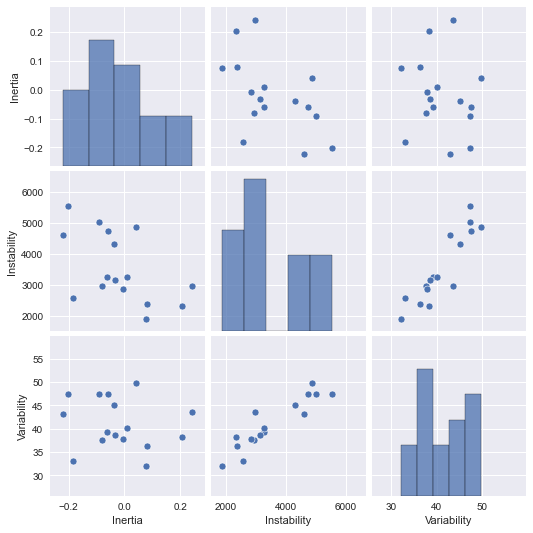

In [22]:
grid = sns.pairplot(X_ed);

# x-axis limits
grid.axes[0,0].set_xlim((min_.Inertia,max_.Inertia))
grid.axes[0,1].set_xlim((min_.Instability,max_.Instability))
grid.axes[0,2].set_xlim((min_.Variability,max_.Variability))
grid.axes[1,0].set_xlim((min_.Inertia,max_.Inertia))
grid.axes[1,1].set_xlim((min_.Instability,max_.Instability))
grid.axes[1,2].set_xlim((min_.Variability,max_.Variability))
grid.axes[2,0].set_xlim((min_.Inertia,max_.Inertia))
grid.axes[2,1].set_xlim((min_.Instability,max_.Instability))
grid.axes[2,2].set_xlim((min_.Variability,max_.Variability))

# y-axis limits
grid.axes[0,0].set_ylim((min_.Inertia,max_.Inertia))
grid.axes[0,1].set_ylim((min_.Inertia,max_.Inertia))
grid.axes[0,2].set_ylim((min_.Inertia,max_.Inertia))
grid.axes[1,0].set_ylim((min_.Instability,max_.Instability))
grid.axes[1,1].set_ylim((min_.Instability,max_.Instability))
grid.axes[1,2].set_ylim((min_.Instability,max_.Instability))
grid.axes[2,0].set_ylim((min_.Variability,max_.Variability))
grid.axes[2,1].set_ylim((min_.Variability,max_.Variability))
grid.axes[2,2].set_ylim((min_.Variability,max_.Variability));

#### Data preprocessing: scaling
Standardize features by removing the mean and scaling to unit variance.

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ed[['Inertia', 'Instability', 'Variability']])
X_scaled = pd.DataFrame(X_scaled, columns={'Inertia', 'Instability', 'Variability'})
X_scaled['p_number'] = X_ed['p_number']
X_scaled.head()

,Inertia,Instability,Variability,p_number
0,-0.303855,1.091102,1.239767,p10
1,-0.141110,0.697543,0.773963,p12
2,0.495656,1.209901,1.690916,p13
3,-1.286661,-0.892967,-1.541383,p15
4,2.062228,-0.529951,0.471130,p17


In [29]:
max_scaled = pd.Series(map(lambda x: x*1.2 if  x > 0 else x*0.8, X_scaled[['Inertia', 'Instability', 'Variability']].max()), 
                       ['Inertia', 'Instability', 'Variability'])
min_scaled = pd.Series(map(lambda x: x*1.2 if  x < 0 else x*0.8, X_scaled[['Inertia', 'Instability', 'Variability']].min()), 
                       ['Inertia', 'Instability', 'Variability'])

#### 3D scatterplot

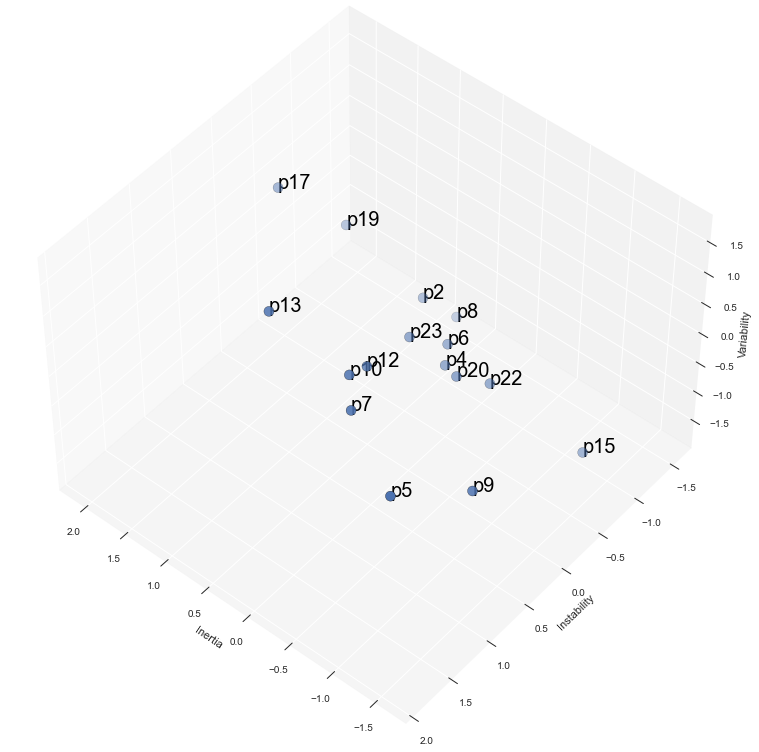

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=130, auto_add_to_figure=False, facecolor='w')
fig.add_axes(ax)

ax.scatter(X_scaled.Inertia, X_scaled.Instability, X_scaled.Variability, 
           cmap=plt.cm.nipy_spectral, edgecolor="k", s=100)
    
for (_, subject) in X_scaled.iterrows(): #plot each point + it's index as text above
    label = subject['p_number']
    ax.text(subject.Inertia,subject.Instability, subject.Variability,  '%s' % label, size=20, zorder=1,  
    color='k') 

ax.set_xlabel('Inertia')
ax.set_ylabel('Instability')
ax.set_zlabel('Variability')

plt.show()



#### Principal Component Analysis

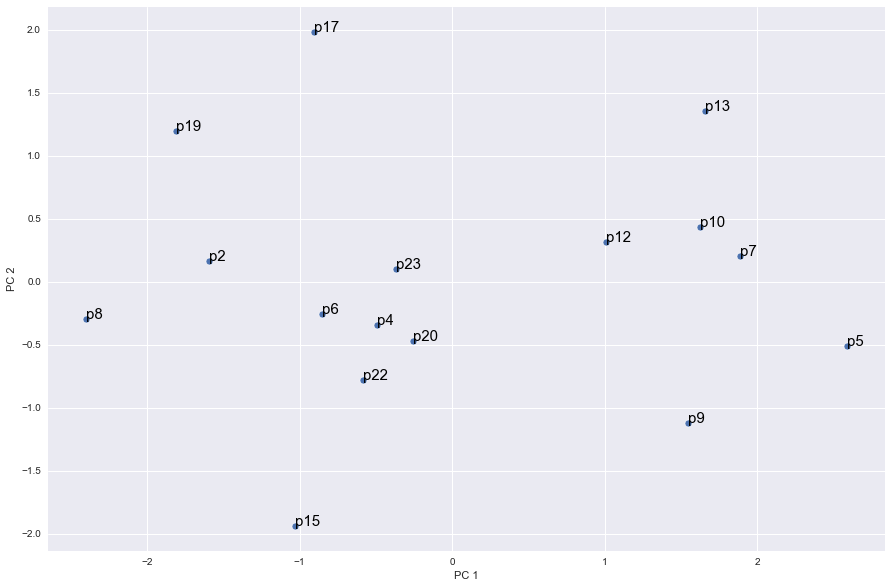

In [71]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled[['Inertia', 'Instability', 'Variability']])
X_PCA = pca.transform(X_scaled[['Inertia', 'Instability', 'Variability']])
X_PCA = pd.DataFrame(X_PCA, columns=['PC1', 'PC2'])
X_PCA['p_number'] = X_scaled['p_number']

fig = plt.figure(figsize=(15,10))
sns.scatterplot(x=X_PCA.PC1, y=X_PCA.PC2);
plt.xlabel('PC 1')
plt.ylabel('PC 2');

for (_, subject) in X_PCA.iterrows(): #plot each point + it's index as text above
    label = subject['p_number']
    plt.text(subject.PC1,subject.PC2, '%s' % label, size=15, zorder=1,  
    color='k') 

#### Gaussian Mixture Model

- Gaussian Mixture Models using information-theoretic criteria (BIC).
- Model selection concerns both the covariance type and the number of components in the model.
- Unlike Bayesian procedures, such inferences are prior-free.

*Adapted from [Gaussian Mixture Model Selection](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#)

In [75]:
import itertools
from scipy import linalg
from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_scaled[['Inertia', 'Instability', 'Variability']])
        bic.append(gmm.bic(X_scaled[['Inertia', 'Instability', 'Variability']]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)

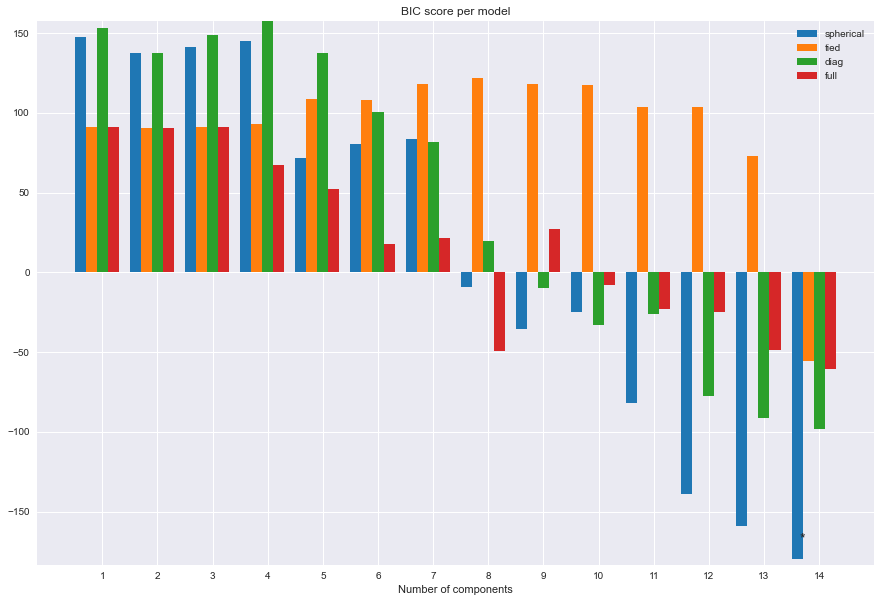

In [76]:
clf = best_gmm

color_iter = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 10))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
plt.xlabel("Number of components")
plt.legend([b[0] for b in bars], cv_types);

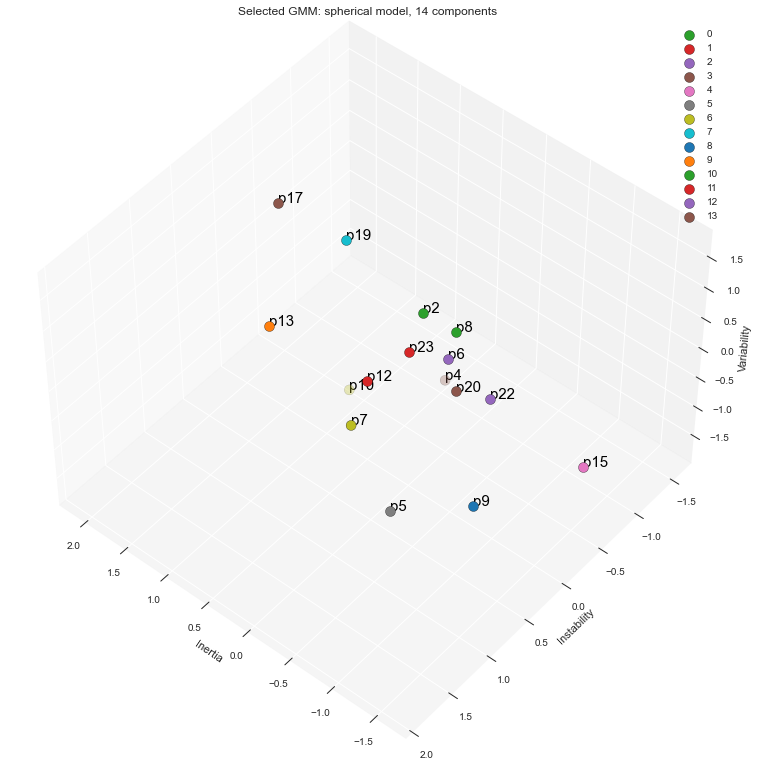

In [80]:
# Plot the winner
fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=130, auto_add_to_figure=False, facecolor='w')
fig.add_axes(ax)
Y_ = clf.predict(X_scaled[['Inertia', 'Instability', 'Variability']])

for i, (mean, color) in enumerate(zip(clf.means_, color_iter)):
    if not np.any(Y_ == i):
        continue
    ax.scatter(X_scaled.Inertia.loc[Y_ == i], X_scaled.Instability.loc[Y_ == i], 
               X_scaled.Variability.loc[Y_ == i], s=100, color=color, edgecolor="k")

for (_, subject) in X_scaled.iterrows(): #plot each point + it's index as text above
    label = subject['p_number']
    ax.text(subject.Inertia,subject.Instability, subject.Variability,  '%s' % label, size=15, zorder=1,  
    color='k') 
    
plt.legend(range(len(clf.means_)))
ax.set_xlabel('Inertia')
ax.set_ylabel('Instability')
ax.set_zlabel('Variability')

plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)


plt.show()

#### Within-participant analysis

The main takeaway so far seems to be that there are no direct archetypes or patterns of response. This seems to suggest that personalized models make sense, given that each participant's response is distinct.

Below is an attempt to address KM's comment:

```Is there any more evidence that it is indeed individualized? Is within-participant behavior consistent?```

Each feeltrace is split in 30 sec chunks, then analyzed within participant.

In [31]:
participant_split = {}
n_samples = int(30*5*60) # sampling rate x n_seconds (3 min)
for index, subject in enumerate(X_list):
    feeltrace = np.array(subject['Feeltrace'])
    n_chunks = int(len(feeltrace)/n_samples)
    participant_split[index] = np.array_split(feeltrace, n_chunks)

In [32]:
ed_participant = {}
grids = []
X_participant_dfs = []

for index, participant in enumerate(participant_split.items()):
    ed_participant[index] = list(map(ED.get_parameters, participant[1]))
    X_participant_dfs.append(pd.DataFrame(ed_participant[index]))
    X_participant_dfs[index]['Participant'] = X_participant_dfs[index].shape[0] * [index]
    X_participant_dfs[index]['Window'] = list(map(lambda x: x, range(X_participant_dfs[index].shape[0])))

In [33]:
from functools import reduce
X_participants = reduce(lambda x, y: pd.concat([x,y], ignore_index = True, sort = False), X_participant_dfs)

In [49]:
X_participants[['Inertia', 'Instability', 'Variability']].head()

,Inertia,Instability,Variability
0,-0.006799,0.562249,24.325250
1,0.021048,0.624189,38.349309
2,-0.161445,1.079878,39.644436
3,-0.190638,0.983516,46.210123
4,0.327486,1.772766,54.534712


In [35]:
max_ = pd.Series(map(lambda x: x*1.2 if  x > 0 else x*0.8, X_participants[['Inertia', 'Instability', 'Variability']].max()), ['Inertia', 'Instability', 'Variability'])
min_ = pd.Series(map(lambda x: x*1.2 if  x < 0 else x*0.8, X_participants[['Inertia', 'Instability', 'Variability']].min()), ['Inertia', 'Instability', 'Variability'])

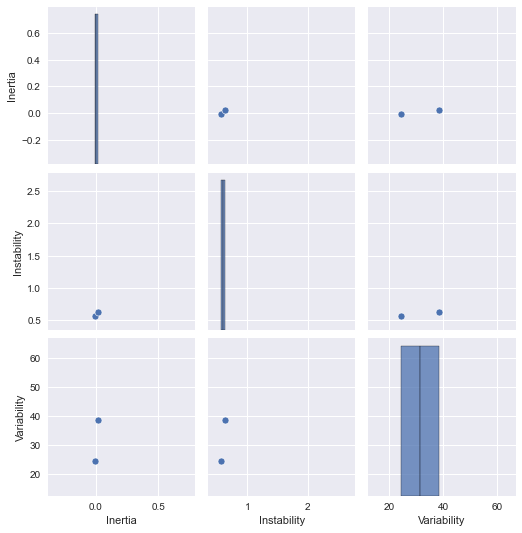

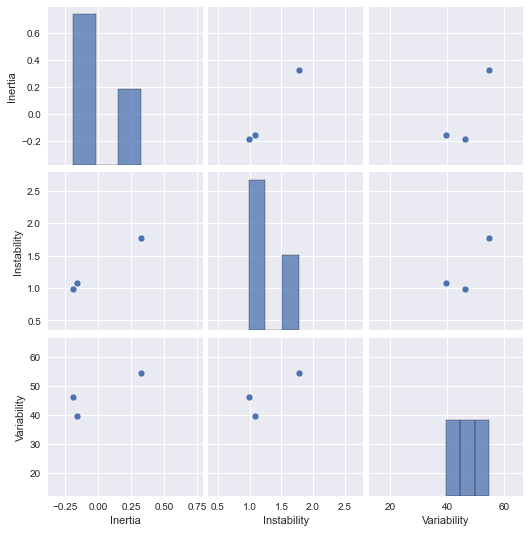

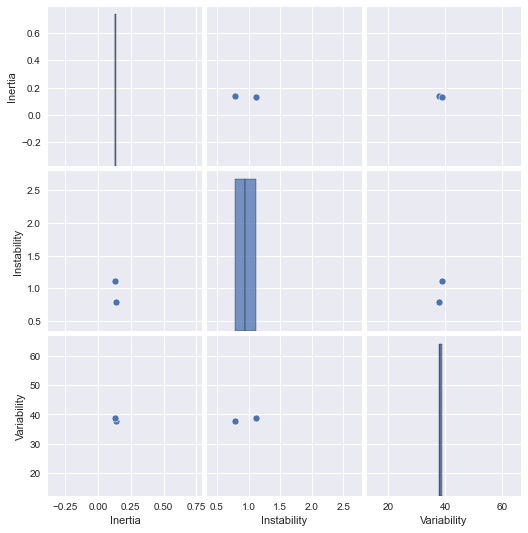

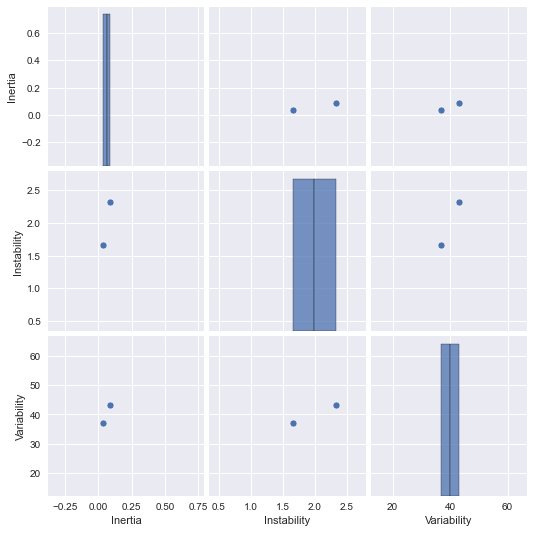

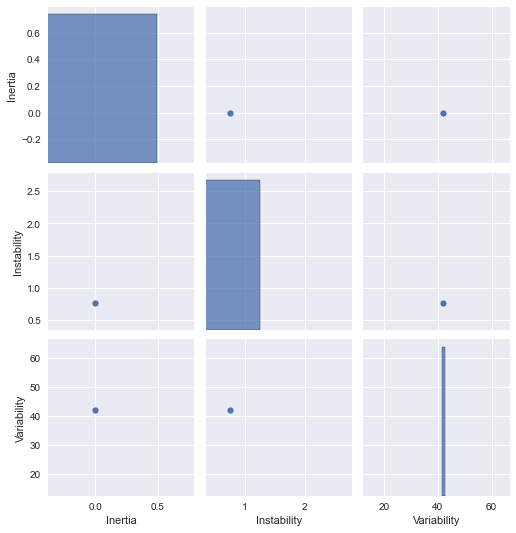

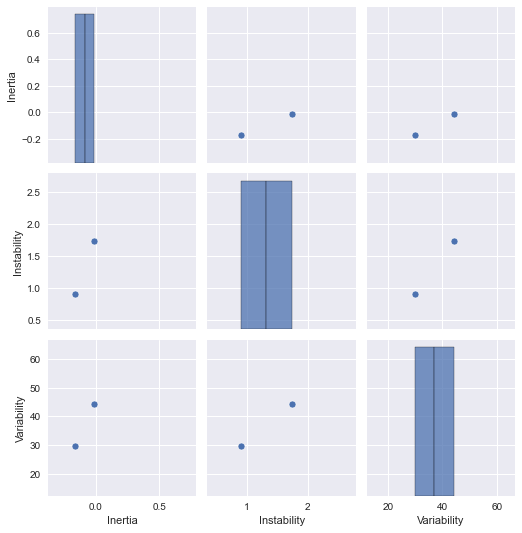

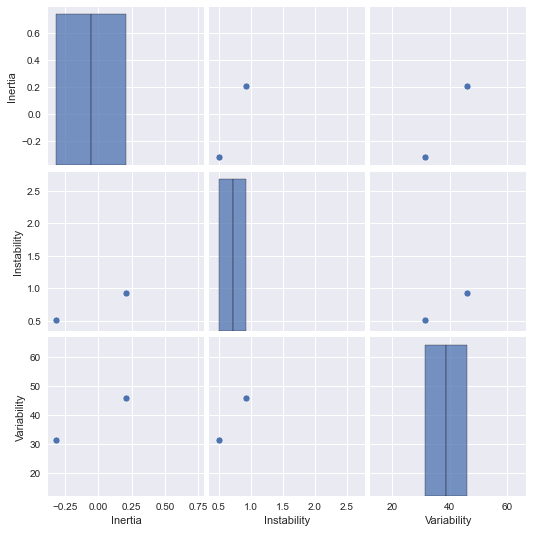

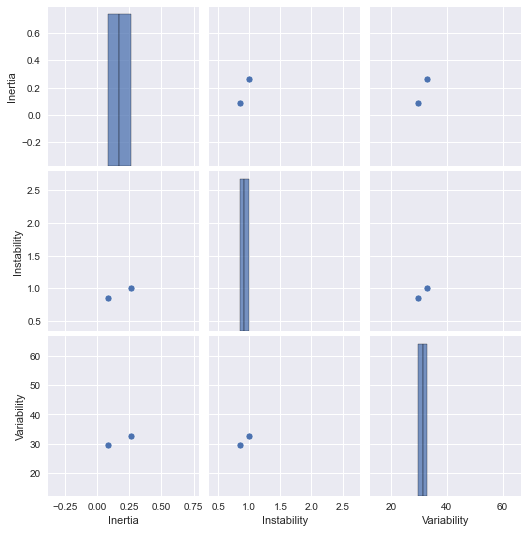

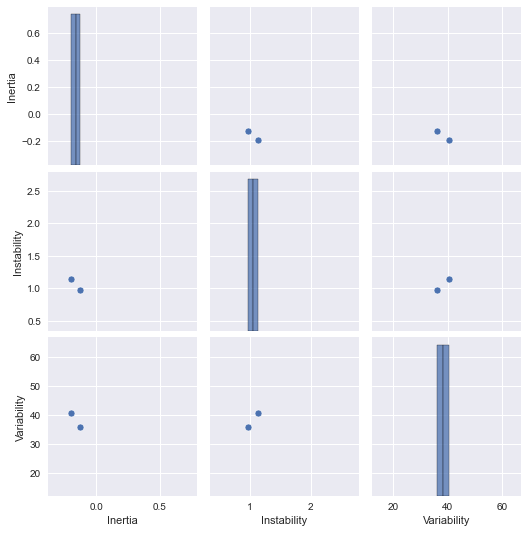

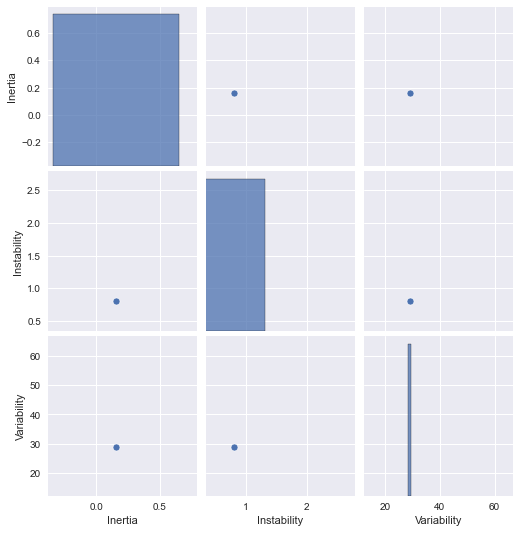

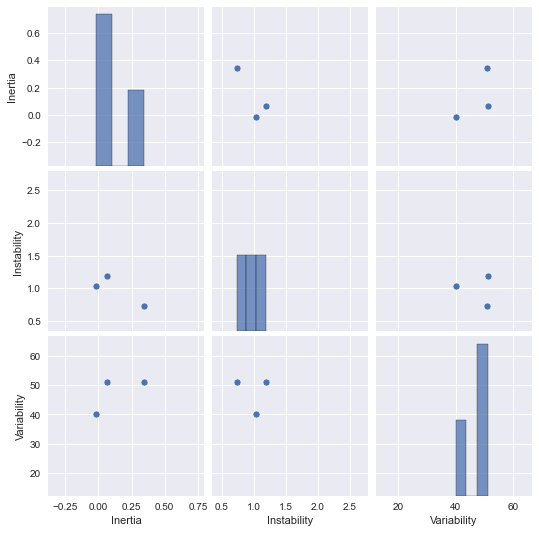

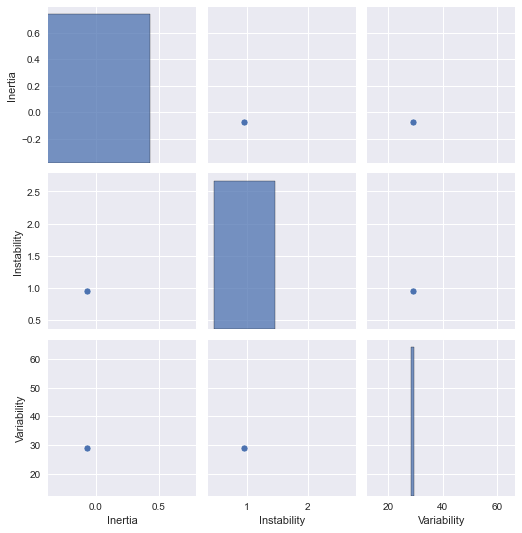

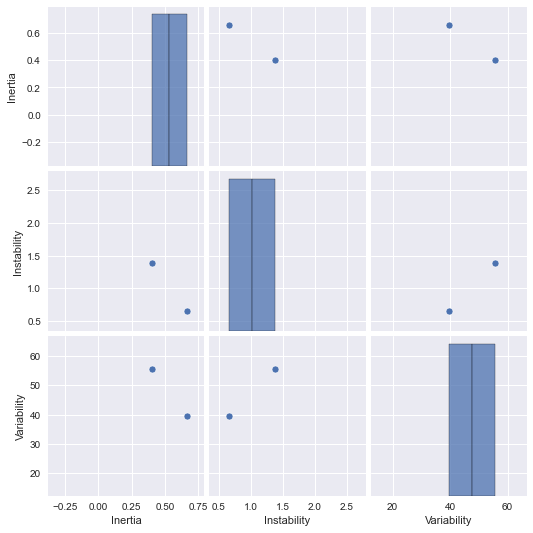

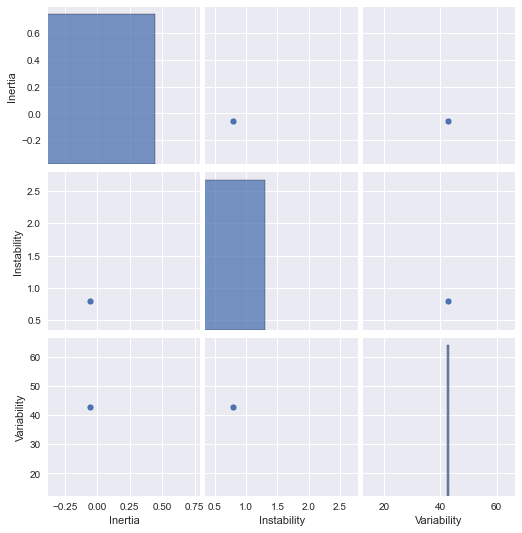

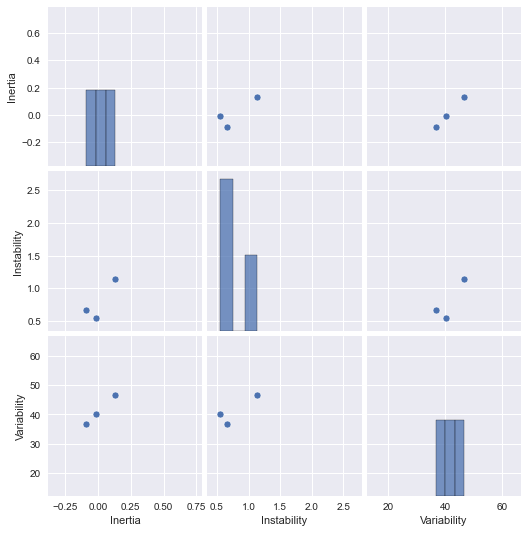

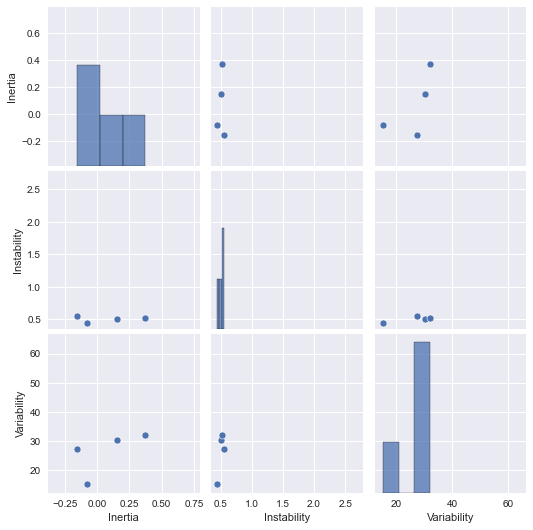

In [36]:
for index, participant in enumerate(participant_split.items()):    
    X_participant = pd.DataFrame(ed_participant[index])
    grid = sns.pairplot(X_participant);# x-axis limits
    grid.axes[0,0].set_xlim((min_.Inertia,max_.Inertia))
    grid.axes[0,1].set_xlim((min_.Instability,max_.Instability))
    grid.axes[0,2].set_xlim((min_.Variability,max_.Variability))
    grid.axes[1,0].set_xlim((min_.Inertia,max_.Inertia))
    grid.axes[1,1].set_xlim((min_.Instability,max_.Instability))
    grid.axes[1,2].set_xlim((min_.Variability,max_.Variability))
    grid.axes[2,0].set_xlim((min_.Inertia,max_.Inertia))
    grid.axes[2,1].set_xlim((min_.Instability,max_.Instability))
    grid.axes[2,2].set_xlim((min_.Variability,max_.Variability))

    # y-axis limits
    grid.axes[0,0].set_ylim((min_.Inertia,max_.Inertia))
    grid.axes[0,1].set_ylim((min_.Inertia,max_.Inertia))
    grid.axes[0,2].set_ylim((min_.Inertia,max_.Inertia))
    grid.axes[1,0].set_ylim((min_.Instability,max_.Instability))
    grid.axes[1,1].set_ylim((min_.Instability,max_.Instability))
    grid.axes[1,2].set_ylim((min_.Instability,max_.Instability))
    grid.axes[2,0].set_ylim((min_.Variability,max_.Variability))
    grid.axes[2,1].set_ylim((min_.Variability,max_.Variability))
    grid.axes[2,2].set_ylim((min_.Variability,max_.Variability))